In [579]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import kaggle as kg

In [580]:
os.environ["USERNAME"] = "ananyachattarjee"
os.environ["KEY"] = "340cf7e2927700b82491dcdaa82ad906"

In [581]:
kg.api.authenticate()

In [582]:
# kg.api.dataset_download_files(dataset="mirichoi0218/insurance",
#                               path="./dataset",unzip=True)

In [583]:
data = pd.read_csv("dataset/insurance.csv")
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [584]:
type(data)

pandas.core.frame.DataFrame

In [585]:
data.isnull().sum()


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [586]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [587]:
CATEGORICAL_COLUMNS = list(data.columns[1:2])+list(data.columns[4:6])
NUMERICAL_COLUMNS = list(set(data.columns).difference(set(CATEGORICAL_COLUMNS)))
TARGET_COLUMN = "charges"

print(CATEGORICAL_COLUMNS)
print(NUMERICAL_COLUMNS)

['sex', 'smoker', 'region']
['charges', 'children', 'age', 'bmi']


In [588]:
type(data)

pandas.core.frame.DataFrame

In [589]:

def label_encode_columns(data):
    data = data.copy()  
    columns_label_encodings = {}

    for column_name in CATEGORICAL_COLUMNS:
        d = {value: data[data[column_name] == value][TARGET_COLUMN].mean() for value in data[column_name].unique()}

        input_target_df = pd.DataFrame({column_name: list(d.keys()), f"Mean {TARGET_COLUMN}": list(d.values())})
        input_target_df.sort_values(by=f"Mean {TARGET_COLUMN}", inplace=True)
        input_target_df.reset_index(drop=True, inplace=True)

        data[column_name] = data[column_name].replace(to_replace=list(input_target_df[column_name]),
                                                      value=list(input_target_df.index)).infer_objects(copy=False)

        columns_label_encodings[column_name] = dict(zip(list(input_target_df[column_name]), list(input_target_df.index)))

    return columns_label_encodings, data


columns_label_encodings, data = label_encode_columns(data)

/tmp/ipykernel_4855/751645864.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[column_name] = data[column_name].replace(to_replace=list(input_target_df[column_name]),


In [590]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,0,16884.92400
1,18,1,33.770,1,0,3,1725.55230
2,28,1,33.000,3,0,3,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,2,2205.98080
1335,18,0,36.850,0,0,3,1629.83350
1336,21,0,25.800,0,0,0,2007.94500


In [591]:

def train_test_split(training_data_frac, data):
    
    training_data_len = int(training_data_frac * data.shape[0])

    
    training_data = data.iloc[:training_data_len]
    testing_data = data.iloc[training_data_len:]

    # Separate features (X) and target (y)
    X_train = training_data.drop(columns=['charges']).copy()  
    y_train = training_data['charges'].copy()  

    X_test = testing_data.drop(columns=['charges']).copy()
    y_test = testing_data['charges'].copy()

    return X_train, y_train, X_test, y_test



In [592]:
X_train, y_train, X_test, y_test = train_test_split(0.7,data)

In [593]:
X_train

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,0
1,18,1,33.770,1,0,3
2,28,1,33.000,3,0,3
3,33,1,22.705,0,0,1
4,32,1,28.880,0,0,1
...,...,...,...,...,...,...
931,39,0,32.500,1,0,0
932,46,1,25.800,5,0,0
933,45,0,35.300,0,0,0
934,32,1,37.180,2,0,3


In [594]:
X_test

,age,sex,bmi,children,smoker,region
936,44,1,29.735,2,0,2
937,39,0,24.225,5,0,1
938,18,1,26.180,2,0,3
939,53,1,29.480,0,0,3
940,18,1,23.210,0,0,3
...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1
1334,18,0,31.920,0,0,2
1335,18,0,36.850,0,0,3
1336,21,0,25.800,0,0,0


In [595]:
def initialize_parameters(n_features):
    theta = np.zeros((n_features, 1))  # Initialize weights (coefficients) to zeros
    return theta


In [596]:
def compute_cost(X, y, theta):
    m = len(y)
    predictions = X.dot(theta)
    cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2, axis=0)
    return float(cost.iloc[0]) if isinstance(cost, pd.Series) else float(cost)



In [597]:
def gradient_descent(X, y, theta, learning_rate, iterations):
    m = len(y)
    cost_history = []

    y = y.values.reshape(-1, 1)

    for i in range(iterations):
        predictions = X.dot(theta)
        error = predictions - y  

        gradient = (1 / m) * X.T.dot(error)
        theta -= learning_rate * gradient

        cost = compute_cost(X, y, theta)
        cost_history.append(cost)

        if i % 100 == 0:
            print(f"Iteration {i}: Cost = {cost:.4f}")

    return theta, cost_history



In [697]:
n_features = X_train.shape[1]
theta = initialize_parameters(n_features)

learning_rate = 0.00074
iterations = 50000

theta_final, cost_history = gradient_descent(X_train, y_train, theta, learning_rate, iterations)


Iteration 0: Cost = 156526021.4440
Iteration 100: Cost = 76364433.5355
Iteration 200: Cost = 63621182.8909
Iteration 300: Cost = 60884447.3944
Iteration 400: Cost = 59653568.2971
Iteration 500: Cost = 58668495.2188
Iteration 600: Cost = 57741476.3467
Iteration 700: Cost = 56843676.0353
Iteration 800: Cost = 55969905.7016
Iteration 900: Cost = 55118575.5543
Iteration 1000: Cost = 54288710.5438
Iteration 1100: Cost = 53479495.7088
Iteration 1200: Cost = 52690198.2511
Iteration 1300: Cost = 51920147.2071
Iteration 1400: Cost = 51168723.1464
Iteration 1500: Cost = 50435350.5921
Iteration 1600: Cost = 49719491.8665
Iteration 1700: Cost = 49020641.9932
Iteration 1800: Cost = 48338324.4543
Iteration 1900: Cost = 47672087.6505
Iteration 2000: Cost = 47021501.9447
Iteration 2100: Cost = 46386157.1853
Iteration 2200: Cost = 45765660.6288
Iteration 2300: Cost = 45159635.1916
Iteration 2400: Cost = 44567717.9748
Iteration 2500: Cost = 43989559.0154
Iteration 2600: Cost = 43424820.2255
Iteration 27

In [698]:
y_pred = X_test.dot(theta_final) 


In [699]:
y_pred

,0
936,9176.975050
937,9945.152815
938,3542.644184
939,10320.774967
940,2948.557285
...,...
1333,10885.376010
1334,4701.345116
1335,4720.589869
1336,5442.928357


In [700]:
y_pred = np.array(y_pred)

In [701]:
print(np.isinf(y_pred).sum())  


0


In [702]:
testing_data

,age,sex,bmi,children,smoker,region,charges
936,44,1,29.735,2,0,2,32108.66282
937,39,0,24.225,5,0,1,8965.79575
938,18,1,26.180,2,0,3,2304.00220
939,53,1,29.480,0,0,3,9487.64420
940,18,1,23.210,0,0,3,1121.87390
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,2,2205.98080
1335,18,0,36.850,0,0,3,1629.83350
1336,21,0,25.800,0,0,0,2007.94500


In [703]:
y_test.shape

(402,)

In [704]:
y_pred.shape

(402, 1)

In [705]:
y_pred = y_pred.flatten()  # Converts (407, 1) → (407,)

In [706]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def r2_score(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")


Mean Absolute Error: 4715.881780277594
Mean Squared Error: 46724888.96807594
R-squared Score: 0.6898623963823868


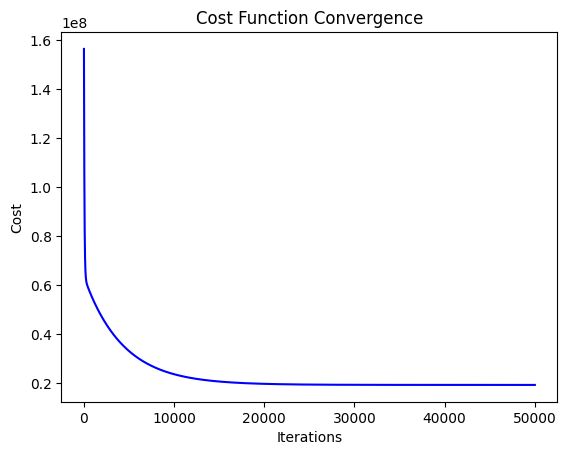

In [707]:
plt.plot(range(iterations), cost_history, color='b')
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost Function Convergence")
plt.show()
